<b><font size='3'>Importing Packages</font></b>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, average_precision_score, log_loss, f1_score, matthews_corrcoef, confusion_matrix, classification_report

from tensorflow.keras.optimizers import Adam

<b><font size='3'>Reading Dataset</font></b>

In [2]:
df = pd.read_csv('Services_Data_Raw.csv')

<b><font size='3'>Analysis 1 - Identified Unnamed Column and Unnecessary Rows</font></b>

In [3]:
df

,Engagement Account,Unnamed: 1,Engagement,Services Contract Revenue,Services Contract Cost,Element,Activity,Resource,Entry Date,Entry Units,Entry Cost,Factored Entry Units,Element End Date
0,(DO NOT USE) Hermes Parcelnet Limited,NaN,Hermes - Additional Days - 05/08/2020,GBP 999.98,GBP 188.00,Project Management,Project Management,Bridget Casement,6/8/2020,2.00,GBP 50.13,2.00,31/03/2021
1,(DO NOT USE) Hermes Parcelnet Limited,NaN,Hermes - Additional Days - 05/08/2020,GBP 999.98,GBP 188.00,Project Management,Project Management,Bridget Casement,13/08/2020,1.00,GBP 25.07,1.00,31/03/2021
2,(DO NOT USE) Hermes Parcelnet Limited,NaN,Hermes - Additional Days - 05/08/2020,GBP 999.98,GBP 188.00,Project Management,Project Management,Bridget Casement,5/8/2020,2.00,GBP 50.13,2.00,31/03/2021
3,(DO NOT USE) Hermes Parcelnet Limited,NaN,Hermes - Additional Days - 05/08/2020,GBP 999.98,GBP 188.00,Project Management,Project Management,Bridget Casement,26/08/2020,1.00,GBP 25.07,1.00,31/03/2021
4,(DO NOT USE) Hermes Parcelnet Limited,NaN,Hermes - Additional Days - 05/08/2020,GBP 999.98,GBP 188.00,Project Management,Project Management,Bridget Casement,27/08/2020,1.50,GBP 37.60,1.50,31/03/2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55861,Zenith Multi Academy Trust,NaN,Migrated PSF:KIN05-3:Zenith Multi Academy Trust,GBP 810.00,GBP 456.63,IRIS Financials Advantage Plus Service,IRIS Financials Advantage Plus Service,Manjit Biant,13/04/2023,7.50,GBP 139.00,7.50,30/06/2023
55862,Zenith Multi Academy Trust,NaN,Migrated PSF:KIN05-3:Zenith Multi Academy Trust,GBP 810.00,GBP 456.63,IRIS Financials Advantage Plus Service,IRIS Financials Advantage Plus Service,Manjit Biant,2/5/2023,1.00,GBP 18.53,1.00,30/06/2023
55863,Zest Academy Trust (The),NaN,Zest Academy Trust (The) PSP 14/12/2021,GBP 499.99,GBP 78.50,001_1: PS People Ad-hoc Consultancy,001_1: PS People Ad-hoc Consultancy,Ben Lightbown,12/1/2023,3.75,GBP 78.50,3.75,2/2/2023
55864,Total,Sum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181443.90,NaN,181443.90,NaN


<b><font size='3'>Data Cleaning 1 - Removed Column, Rows, & Duplicates</font></b>

In [4]:
df = df.drop_duplicates().iloc[:-2].reset_index(drop = True)

In [5]:
df = df.drop(df.columns[1], axis = 1)

<b><font size='3'>Data Cleaning 2 - Removed GBP & Comma from Numerical Columns for Data Consistency </font></b>

In [6]:
clean_currency = ['Entry Cost', 'Services Contract Cost', 'Services Contract Revenue']

In [7]:
for column in clean_currency:
    df[column] = df[column].apply(lambda x: float(x.replace('GBP', '').replace(',', '')))

<b><font size='3'>Feature Engineering 1 - Calculated Revenue</font></b>

In [8]:
df['Revenue'] = (df['Entry Cost'] / df['Services Contract Cost']) * df['Services Contract Revenue']

In [9]:
df['Revenue'] = df['Revenue'].round(2)

<b><font size='3'>Feature Engineering 2 - Calculated Duration</font></b>

In [10]:
df['Entry Date'] = pd.to_datetime(df['Entry Date'], dayfirst = True)
df['Element End Date'] = pd.to_datetime(df['Element End Date'], dayfirst = True)

In [11]:
df['Duration Days'] = (df['Element End Date'] - df['Entry Date']).dt.days

<b><font size='3'>Data Cleaning 3 - Sorted Column Order </font></b>

In [12]:
column_order = ['Engagement Account', 'Engagement', 'Element', 'Activity', 'Resource', 
                'Entry Date', 'Element End Date', 'Duration Days', 
                'Factored Entry Units', 'Entry Units', 
                'Entry Cost', 'Services Contract Cost', 'Services Contract Revenue', 'Revenue']

In [13]:
df = df.reindex(columns = column_order)

<b><font size='3'>Analysis 2 - Identified Infinity Values from Revenue</font></b>

In [14]:
df

,Engagement Account,Engagement,Element,Activity,Resource,Entry Date,Element End Date,Duration Days,Factored Entry Units,Entry Units,Entry Cost,Services Contract Cost,Services Contract Revenue,Revenue
0,(DO NOT USE) Hermes Parcelnet Limited,Hermes - Additional Days - 05/08/2020,Project Management,Project Management,Bridget Casement,2020-08-06,2021-03-31,237,2.00,2.00,50.13,188.00,999.98,266.64
1,(DO NOT USE) Hermes Parcelnet Limited,Hermes - Additional Days - 05/08/2020,Project Management,Project Management,Bridget Casement,2020-08-13,2021-03-31,230,1.00,1.00,25.07,188.00,999.98,133.35
2,(DO NOT USE) Hermes Parcelnet Limited,Hermes - Additional Days - 05/08/2020,Project Management,Project Management,Bridget Casement,2020-08-05,2021-03-31,238,2.00,2.00,50.13,188.00,999.98,266.64
3,(DO NOT USE) Hermes Parcelnet Limited,Hermes - Additional Days - 05/08/2020,Project Management,Project Management,Bridget Casement,2020-08-26,2021-03-31,217,1.00,1.00,25.07,188.00,999.98,133.35
4,(DO NOT USE) Hermes Parcelnet Limited,Hermes - Additional Days - 05/08/2020,Project Management,Project Management,Bridget Casement,2020-08-27,2021-03-31,216,1.50,1.50,37.60,188.00,999.98,200.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54962,Zenith Multi Academy Trust,Zenith - IF - Doc Attach - 25/05/22,IRIS Financials Education Ad Hoc Consultancy,IRIS Financials Education Ad Hoc Consultancy,Veerinder Bhoda,2022-09-14,2022-09-14,0,7.50,7.50,157.00,157.00,699.98,699.98
54963,Zenith Multi Academy Trust,Migrated PSF:KIN05-3:Zenith Multi Academy Trust,IRIS Financials Advantage Plus Service,IRIS Financials Advantage Plus Service,Amira Varia,2023-04-24,2023-06-30,67,3.75,3.75,69.50,456.63,810.00,123.28
54964,Zenith Multi Academy Trust,Migrated PSF:KIN05-3:Zenith Multi Academy Trust,IRIS Financials Advantage Plus Service,IRIS Financials Advantage Plus Service,Manjit Biant,2023-04-13,2023-06-30,78,7.50,7.50,139.00,456.63,810.00,246.57
54965,Zenith Multi Academy Trust,Migrated PSF:KIN05-3:Zenith Multi Academy Trust,IRIS Financials Advantage Plus Service,IRIS Financials Advantage Plus Service,Manjit Biant,2023-05-02,2023-06-30,59,1.00,1.00,18.53,456.63,810.00,32.87


In [15]:
df.describe()

,Duration Days,Factored Entry Units,Entry Units,Entry Cost,Services Contract Cost,Services Contract Revenue,Revenue
count,54967.000000,54967.000000,54967.000000,54967.000000,54967.000000,54967.000000,54967.000
mean,150.244729,3.254801,3.254801,66.783820,1053.726093,4243.224408,inf
std,231.306318,2.726369,2.726369,54.652264,1624.871606,7554.974094,NaN
min,0.000000,-2.000000,-2.000000,-41.870000,0.000000,-1236.670000,-862.290
25%,1.000000,1.000000,1.000000,18.800000,157.000000,195.300000,19.925
50%,58.000000,2.500000,2.500000,52.330000,449.230000,1949.960000,156.000
75%,179.000000,6.500000,6.500000,133.000000,1265.340000,6160.000000,497.480
max,2100.000000,15.000000,15.000000,319.000000,27607.570000,123288.910000,inf


In [16]:
df.sort_values(by = 'Revenue', ascending = False).head()

,Engagement Account,Engagement,Element,Activity,Resource,Entry Date,Element End Date,Duration Days,Factored Entry Units,Entry Units,Entry Cost,Services Contract Cost,Services Contract Revenue,Revenue
7713,Bruntwood Group Limited,Bruntwood - Cascade - 14/06/2021,General Ledger Configuration,General Ledger Configuration,Simon Clark-Jones,2022-07-18,2022-12-18,153,6.5,6.5,136.07,0.00,994.95,inf
7712,Bruntwood Group Limited,Bruntwood - Cascade - 14/06/2021,General Ledger Configuration,General Ledger Configuration,Jacqui Fahey,2022-07-01,2022-12-18,170,1.0,1.0,20.93,0.00,994.95,inf
4689,Azets,IRIS Cascade HR - Azets Read Only License - Fr...,Read Only Access,Read Only Access,Martin Hughes,2022-03-11,2022-03-11,0,1.0,1.0,18.53,18.53,11107.00,11107.00
13276,Demelza Childrens Hospice,Demelza - Expenses + Cascade - 15/06/22,001_1: Expenses + Selenity Onsite Implementation,001_1: Expenses + Selenity Onsite Implementation,Stacey Kirton,2022-06-20,2022-08-21,62,1.0,1.0,25.07,25.07,8066.00,8066.00
26838,Latchways Plc,Latchways PLC - Payrite Read-only License - 02...,IRIS Payrite Custom import/export,IRIS Payrite Custom import/export,Ben Paul,2023-03-16,2023-03-16,0,7.5,7.5,157.00,157.00,7418.32,7418.32


<b><font size='3'>Data Cleaning 4 - Set Infinite Values to Zero</font></b>

In [17]:
df['Revenue'].replace([np.inf, -np.inf], 0, inplace = True)

In [18]:
df.sort_values(by = 'Revenue', ascending = False).head()

,Engagement Account,Engagement,Element,Activity,Resource,Entry Date,Element End Date,Duration Days,Factored Entry Units,Entry Units,Entry Cost,Services Contract Cost,Services Contract Revenue,Revenue
4689,Azets,IRIS Cascade HR - Azets Read Only License - Fr...,Read Only Access,Read Only Access,Martin Hughes,2022-03-11,2022-03-11,0,1.00,1.00,18.53,18.53,11107.00,11107.00
13276,Demelza Childrens Hospice,Demelza - Expenses + Cascade - 15/06/22,001_1: Expenses + Selenity Onsite Implementation,001_1: Expenses + Selenity Onsite Implementation,Stacey Kirton,2022-06-20,2022-08-21,62,1.00,1.00,25.07,25.07,8066.00,8066.00
26838,Latchways Plc,Latchways PLC - Payrite Read-only License - 02...,IRIS Payrite Custom import/export,IRIS Payrite Custom import/export,Ben Paul,2023-03-16,2023-03-16,0,7.50,7.50,157.00,157.00,7418.32,7418.32
4775,Barcrest Group Ltd,Amendment for contract #00033466,IRIS Payrite Custom import/export,IRIS Payrite Custom import/export,Adnan Yusuf,2023-02-28,2023-02-28,0,7.50,7.50,188.00,188.00,7182.00,7182.00
45091,Storal Learning Ltd,Storal Learning - Cascade Recruitment Plus - 1...,Recruitment + Recruitment + Implementation Core 5,Recruitment + Recruitment + Implementation Core 5,Darren Lawton,2021-04-09,2021-05-17,38,3.75,3.75,69.50,94.57,8000.00,5879.24


<b><font size='3'>Analysis 3 - Identified Unecessary Columns</font></b>

In [19]:
df['Element'].equals(df['Activity'])

True

In [20]:
df['Entry Units'].equals(df['Factored Entry Units'])

True

<b><font size='3'>Data Cleaning 5 - Removed Unnecessary Columns</font></b>

In [21]:
drop_col = ['Factored Entry Units', 'Activity']

In [22]:
df.drop(columns = drop_col, inplace = True)

<b><font size='3'>Data Cleaning 6 - Removed Uncessary Values & Parsed Date</font></b>

In [23]:
date_pattern = r'(\d{1,2}[/.]\d{1,2}[/.]\d{2,4}|\d{1,2}\s\d{1,2}\s\d{2,4}|[A-Za-z]{3}\s\d{1,2},?\s?\d{2,4})'

In [24]:
df['Sign Date'] = pd.to_datetime(
    df['Engagement'].str.extract(date_pattern, expand = False),
    format = '%m/%d/%Y', errors = 'coerce')

In [25]:
df['Engagement'] = df['Engagement'].str.replace(r'\d{1,2}[/.]\d{1,2}[/.]\d{2,4}', '', regex = True)
df['Engagement'] = df['Engagement'].str.rstrip(' - ')

In [26]:
df['Engagement Account'] = df['Engagement Account'].str.replace(r'\(.*\)', '', regex = True)

In [27]:
df['Engagement'] = df['Engagement'].str.strip()
df['Engagement Account'] = df['Engagement Account'].str.strip()

<b><font size='3'>Data Cleaning 7 - Sorted Column Order</font></b>

In [28]:
column_order = ['Engagement Account', 'Engagement', 'Element', 'Resource', 
                'Sign Date', 'Entry Date', 'Element End Date', 'Duration Days', 
                'Entry Units', 'Entry Cost', 
                'Services Contract Cost', 'Services Contract Revenue', 'Revenue']

In [29]:
df = df.reindex(columns = column_order)

<b><font size='3'>Analysis 4 - Data Overview</font></b>

In [30]:
df

,Engagement Account,Engagement,Element,Resource,Sign Date,Entry Date,Element End Date,Duration Days,Entry Units,Entry Cost,Services Contract Cost,Services Contract Revenue,Revenue
0,Hermes Parcelnet Limited,Hermes - Additional Days,Project Management,Bridget Casement,2020-05-08,2020-08-06,2021-03-31,237,2.00,50.13,188.00,999.98,266.64
1,Hermes Parcelnet Limited,Hermes - Additional Days,Project Management,Bridget Casement,2020-05-08,2020-08-13,2021-03-31,230,1.00,25.07,188.00,999.98,133.35
2,Hermes Parcelnet Limited,Hermes - Additional Days,Project Management,Bridget Casement,2020-05-08,2020-08-05,2021-03-31,238,2.00,50.13,188.00,999.98,266.64
3,Hermes Parcelnet Limited,Hermes - Additional Days,Project Management,Bridget Casement,2020-05-08,2020-08-26,2021-03-31,217,1.00,25.07,188.00,999.98,133.35
4,Hermes Parcelnet Limited,Hermes - Additional Days,Project Management,Bridget Casement,2020-05-08,2020-08-27,2021-03-31,216,1.50,37.60,188.00,999.98,200.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54962,Zenith Multi Academy Trust,Zenith - IF - Doc Attach,IRIS Financials Education Ad Hoc Consultancy,Veerinder Bhoda,NaT,2022-09-14,2022-09-14,0,7.50,157.00,157.00,699.98,699.98
54963,Zenith Multi Academy Trust,Migrated PSF:KIN05-3:Zenith Multi Academy Trust,IRIS Financials Advantage Plus Service,Amira Varia,NaT,2023-04-24,2023-06-30,67,3.75,69.50,456.63,810.00,123.28
54964,Zenith Multi Academy Trust,Migrated PSF:KIN05-3:Zenith Multi Academy Trust,IRIS Financials Advantage Plus Service,Manjit Biant,NaT,2023-04-13,2023-06-30,78,7.50,139.00,456.63,810.00,246.57
54965,Zenith Multi Academy Trust,Migrated PSF:KIN05-3:Zenith Multi Academy Trust,IRIS Financials Advantage Plus Service,Manjit Biant,NaT,2023-05-02,2023-06-30,59,1.00,18.53,456.63,810.00,32.87


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54967 entries, 0 to 54966
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Engagement Account         54967 non-null  object        
 1   Engagement                 54967 non-null  object        
 2   Element                    54967 non-null  object        
 3   Resource                   54967 non-null  object        
 4   Sign Date                  7585 non-null   datetime64[ns]
 5   Entry Date                 54967 non-null  datetime64[ns]
 6   Element End Date           54967 non-null  datetime64[ns]
 7   Duration Days              54967 non-null  int64         
 8   Entry Units                54967 non-null  float64       
 9   Entry Cost                 54967 non-null  float64       
 10  Services Contract Cost     54967 non-null  float64       
 11  Services Contract Revenue  54967 non-null  float64       
 12  Reve

In [32]:
df.describe()

,Duration Days,Entry Units,Entry Cost,Services Contract Cost,Services Contract Revenue,Revenue
count,54967.000000,54967.000000,54967.000000,54967.000000,54967.000000,54967.000000
mean,150.244729,3.254801,66.783820,1053.726093,4243.224408,317.257548
std,231.306318,2.726369,54.652264,1624.871606,7554.974094,386.871395
min,0.000000,-2.000000,-41.870000,0.000000,-1236.670000,-862.290000
25%,1.000000,1.000000,18.800000,157.000000,195.300000,19.870000
50%,58.000000,2.500000,52.330000,449.230000,1949.960000,156.000000
75%,179.000000,6.500000,133.000000,1265.340000,6160.000000,497.480000
max,2100.000000,15.000000,319.000000,27607.570000,123288.910000,11107.000000


In [33]:
df.select_dtypes(include = 'object').nunique().sort_values(ascending = False)

Engagement            9088
Engagement Account    4129
Element               2593
Resource               180
dtype: int64

In [34]:
def plot_top_frequent(column, n = 10):
    top_items = df[column].value_counts().head(n)
    
    plt.figure(figsize=(10, 4))
    ax = sns.barplot(x=top_items.values, y = top_items.index, orient = 'h', palette = 'flare')
    ax.set_title(f'Top {n} Frequent {column}')
    ax.set_xlabel('Count')
    ax.set_ylabel(column)
    
    for p in ax.patches:
        ax.annotate(f"{p.get_width():.0f}", (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha = 'right', va = 'center', xytext = (-5, 0), textcoords = 'offset points')
    
    plt.tight_layout()
    plt.show()

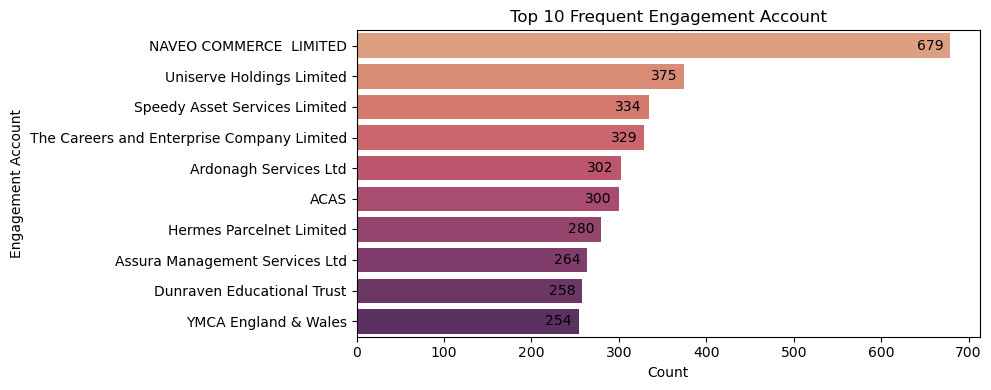

In [35]:
plot_top_frequent('Engagement Account', 10)

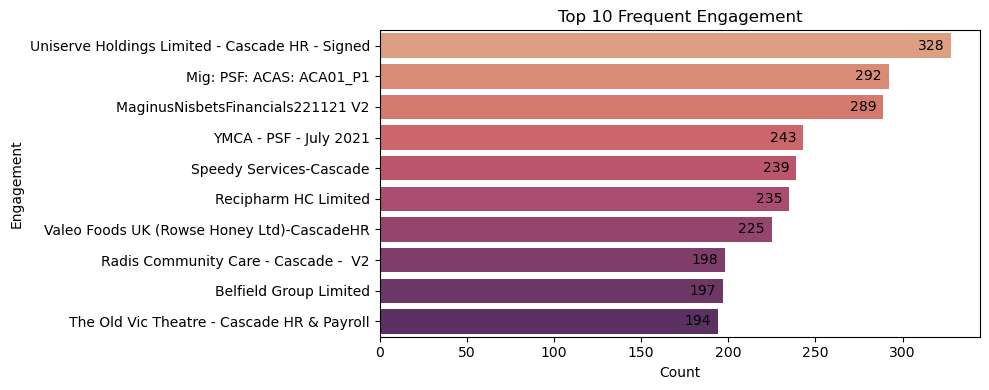

In [36]:
plot_top_frequent('Engagement', 10)

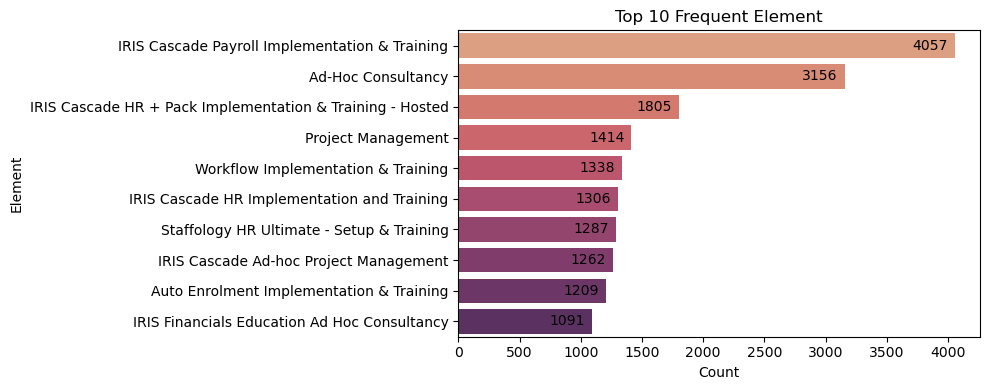

In [37]:
plot_top_frequent('Element', 10)

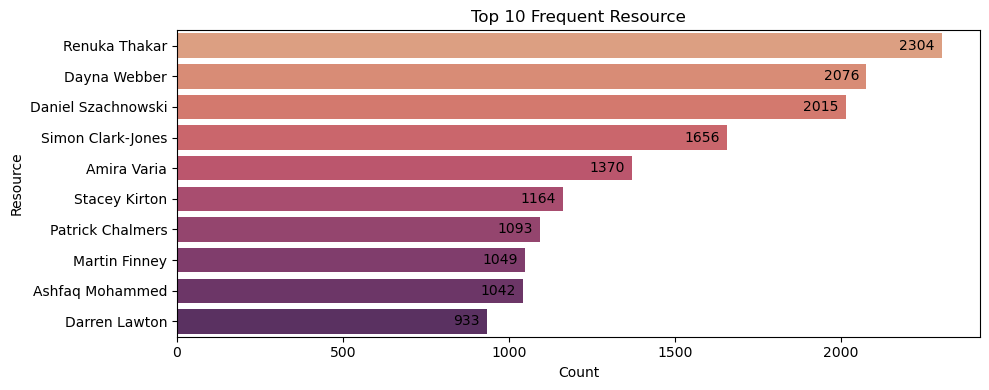

In [38]:
plot_top_frequent('Resource', 10)

In [39]:
renuka_data = df[df['Resource'] == 'Renuka Thakar']
renuka_data['Element'].value_counts().head(5)

IRIS Financials Commercial Ad Hoc Project Management                                180
IRIS Financials Education Accounting Suite Install                                   96
IRIS Financials Commercial V6 Accounting Data Mig & Interfaces (Inst) - Std Only     95
IRIS Financials Education Ad Hoc Consultancy                                         92
IRIS Financials Commercial Ad Hoc Consultancy                                        78
Name: Element, dtype: int64

In [40]:
dayna_data = df[df['Resource'] == 'Dayna Webber']
dayna_data['Element'].value_counts().head(5)

IRIS Cascade Payroll Implementation & Training                301
IRIS Cascade HR + Pack Implementation & Training - Hosted     235
IRIS Cascade Ad-hoc Project Management                        187
IRIS Cascade - ICMS Implementation 1 Company 250 Employees    140
Auto Enrolment Implementation & Training                       99
Name: Element, dtype: int64

In [41]:
monthly_revenue = df.groupby(df['Entry Date'].dt.to_period('M'))['Revenue'].sum()

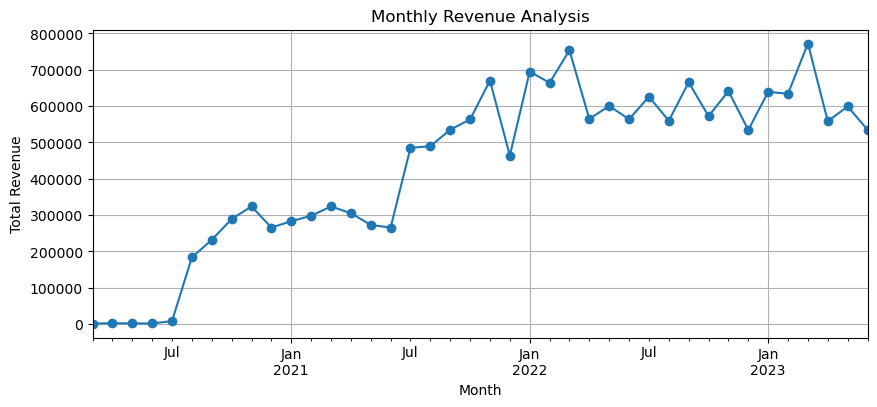

In [42]:
plt.figure(figsize=(10, 4))
monthly_revenue.plot(kind='line', marker='o')
plt.title("Monthly Revenue Analysis")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.show()

In [43]:
num_analysis = df.select_dtypes(include = ['int64', 'float64']).columns

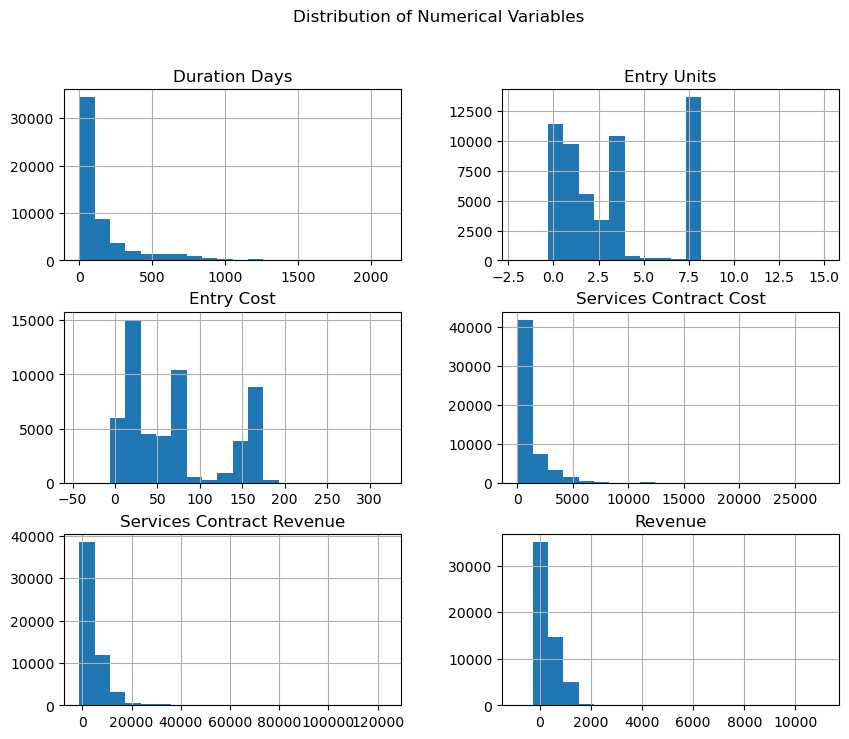

In [44]:
df[num_analysis].hist(bins = 20, figsize = (10, 8))
plt.suptitle("Distribution of Numerical Variables")
plt.show()

In [45]:
feature_outlier = ['Duration Days', 'Entry Units', 'Entry Cost', 'Services Contract Cost', 'Services Contract Revenue', 'Revenue']

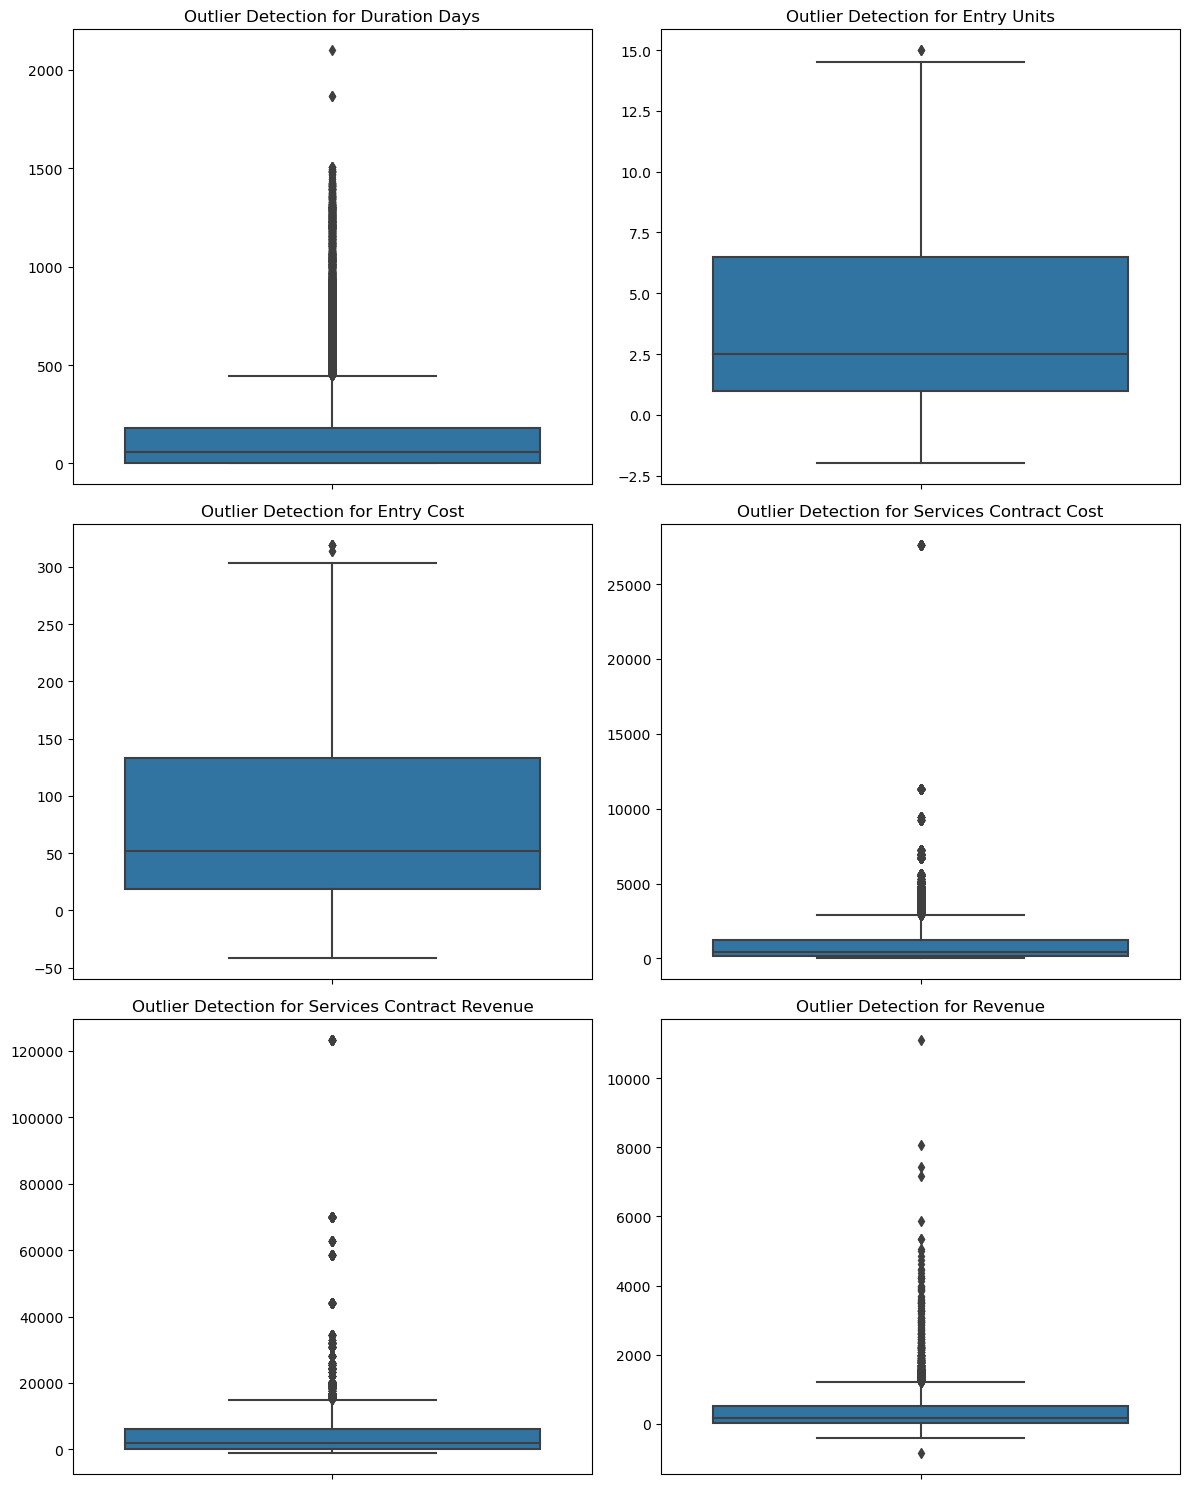

In [46]:
num_plots = len(feature_outlier)
num_cols = 2
num_rows = -(-num_plots // num_cols)

fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (12, 5 * num_rows))

axes_flat = axes.flatten()

for idx, (column, ax) in enumerate(zip(feature_outlier, axes_flat)):
    sns.boxplot(data = df, y = column, ax = ax)
    ax.set_title(f"Outlier Detection for {column}")
    ax.set_ylabel('')
    ax.tick_params(axis = 'x', rotation = 45)
    
for i in range(num_plots, len(axes_flat)):
    axes_flat[i].axis('off')

plt.tight_layout()
plt.show()

In [47]:
# Identify the 'Duration' Outlier

df.sort_values(by = 'Duration Days', ascending = False).head(5)

,Engagement Account,Engagement,Element,Resource,Sign Date,Entry Date,Element End Date,Duration Days,Entry Units,Entry Cost,Services Contract Cost,Services Contract Revenue,Revenue
17018,Extend Learning Academies Network,Extend Learning Academies Network - Ed:Gen,IRIS PlusPay Online Payments Implementation Mu...,James Curran,NaT,2022-04-01,2027-12-31,2100,0.5,12.53,100.89,0.00,0.00
8755,CD & R Galaxy UK Opco Ltd,CD & R Galaxy UK Opco Ltd IRIS Payroll Profess...,IPP vPA Implementation and Training,Richard Pickering,NaT,2023-02-23,2028-04-03,1866,7.5,139.00,739.93,2800.00,526.00
8754,CD & R Galaxy UK Opco Ltd,CD & R Galaxy UK Opco Ltd IRIS Payroll Profess...,IPP vPA Implementation and Training,Richard Pickering,NaT,2023-02-24,2028-04-03,1865,7.5,139.00,739.93,2800.00,526.00
274,ACAS,Mig: PSF: ACAS: ACA01_P1,IRIS Financials Education Accounting Suite Ins...,Renuka Thakar,NaT,2021-07-07,2025-08-22,1507,0.5,6.67,7254.13,44090.64,40.54
273,ACAS,Mig: PSF: ACAS: ACA01_P1,IRIS Financials Education Accounting Suite Ins...,Renuka Thakar,NaT,2021-07-08,2025-08-22,1506,0.5,6.67,7254.13,44090.64,40.54


In [48]:
# Identify the 'Entry Units' Outlier

df.sort_values(by = 'Entry Units', ascending = False).head(5)

,Engagement Account,Engagement,Element,Resource,Sign Date,Entry Date,Element End Date,Duration Days,Entry Units,Entry Cost,Services Contract Cost,Services Contract Revenue,Revenue
3078,Ardonagh Services Ltd,Ardonagh - Cascade - Training Day,Payroll Training - DO NOT USE (E000854-001),Simon Clark-Jones,2020-11-11,2022-02-25,2022-02-25,0,15.00,314.00,314.00,-862.29,-862.29
52063,Venn Group Ltd,Migrated CASENT Ref: VENN01,Payroll Training,Simon Clark-Jones,NaT,2020-12-24,2020-12-24,0,15.00,314.00,314.00,1990.00,1990.00
9745,CIFAS,CIFAS - Cascade Enterprise,IRIS Cascade Payroll Implementation & Training,Simon Clark-Jones,NaT,2021-10-29,2021-10-29,0,14.50,303.53,2190.29,15635.11,2166.71
9744,CIFAS,CIFAS - Cascade Enterprise,IRIS Cascade Payroll Implementation & Training,Simon Clark-Jones,NaT,2021-10-28,2021-10-29,1,14.50,303.53,2190.29,15635.11,2166.71
16849,Evotec SE,Evotec - Data Extract Services,HR Database Extract to Excel,Amira Varia,NaT,2021-06-28,2021-06-28,0,11.25,208.50,278.00,1989.90,1492.43


In [49]:
# Identify the 'Services Contract Cost' Outlier

df.sort_values(by = 'Services Contract Cost', ascending = False).head(5)

,Engagement Account,Engagement,Element,Resource,Sign Date,Entry Date,Element End Date,Duration Days,Entry Units,Entry Cost,Services Contract Cost,Services Contract Revenue,Revenue
31952,NAVEO COMMERCE LIMITED,MaginusNisbetsFinancials221121 V2,IRIS Financials Commercial Ad Hoc Consultancy,Richard Worton,NaT,2022-10-07,2024-12-31,816,7.50,157.00,27607.57,123288.91,701.13
31990,NAVEO COMMERCE LIMITED,MaginusNisbetsFinancials221121 V2,IRIS Financials Commercial Ad Hoc Consultancy,Andrew Jones,NaT,2022-10-27,2024-12-31,796,2.00,41.87,27607.57,123288.91,186.98
31979,NAVEO COMMERCE LIMITED,MaginusNisbetsFinancials221121 V2,IRIS Financials Commercial Ad Hoc Consultancy,Richard Worton,NaT,2022-09-26,2024-12-31,827,3.75,78.50,27607.57,123288.91,350.56
31980,NAVEO COMMERCE LIMITED,MaginusNisbetsFinancials221121 V2,IRIS Financials Commercial Ad Hoc Consultancy,Richard Worton,NaT,2022-09-14,2024-12-31,839,7.50,157.00,27607.57,123288.91,701.13
31981,NAVEO COMMERCE LIMITED,MaginusNisbetsFinancials221121 V2,IRIS Financials Commercial Ad Hoc Consultancy,Richard Worton,NaT,2022-09-20,2024-12-31,833,7.50,157.00,27607.57,123288.91,701.13


In [50]:
# Identify the 'Revenue' Outlier

df.sort_values(by = 'Revenue', ascending = False).head(5)

,Engagement Account,Engagement,Element,Resource,Sign Date,Entry Date,Element End Date,Duration Days,Entry Units,Entry Cost,Services Contract Cost,Services Contract Revenue,Revenue
4689,Azets,IRIS Cascade HR - Azets Read Only License - From,Read Only Access,Martin Hughes,2021-01-10,2022-03-11,2022-03-11,0,1.00,18.53,18.53,11107.00,11107.00
13276,Demelza Childrens Hospice,Demelza - Expenses + Cascade,001_1: Expenses + Selenity Onsite Implementation,Stacey Kirton,NaT,2022-06-20,2022-08-21,62,1.00,25.07,25.07,8066.00,8066.00
26838,Latchways Plc,Latchways PLC - Payrite Read-only License,IRIS Payrite Custom import/export,Ben Paul,NaT,2023-03-16,2023-03-16,0,7.50,157.00,157.00,7418.32,7418.32
4775,Barcrest Group Ltd,Amendment for contract #00033466,IRIS Payrite Custom import/export,Adnan Yusuf,NaT,2023-02-28,2023-02-28,0,7.50,188.00,188.00,7182.00,7182.00
45091,Storal Learning Ltd,Storal Learning - Cascade Recruitment Plus - 1...,Recruitment + Recruitment + Implementation Core 5,Darren Lawton,NaT,2021-04-09,2021-05-17,38,3.75,69.50,94.57,8000.00,5879.24


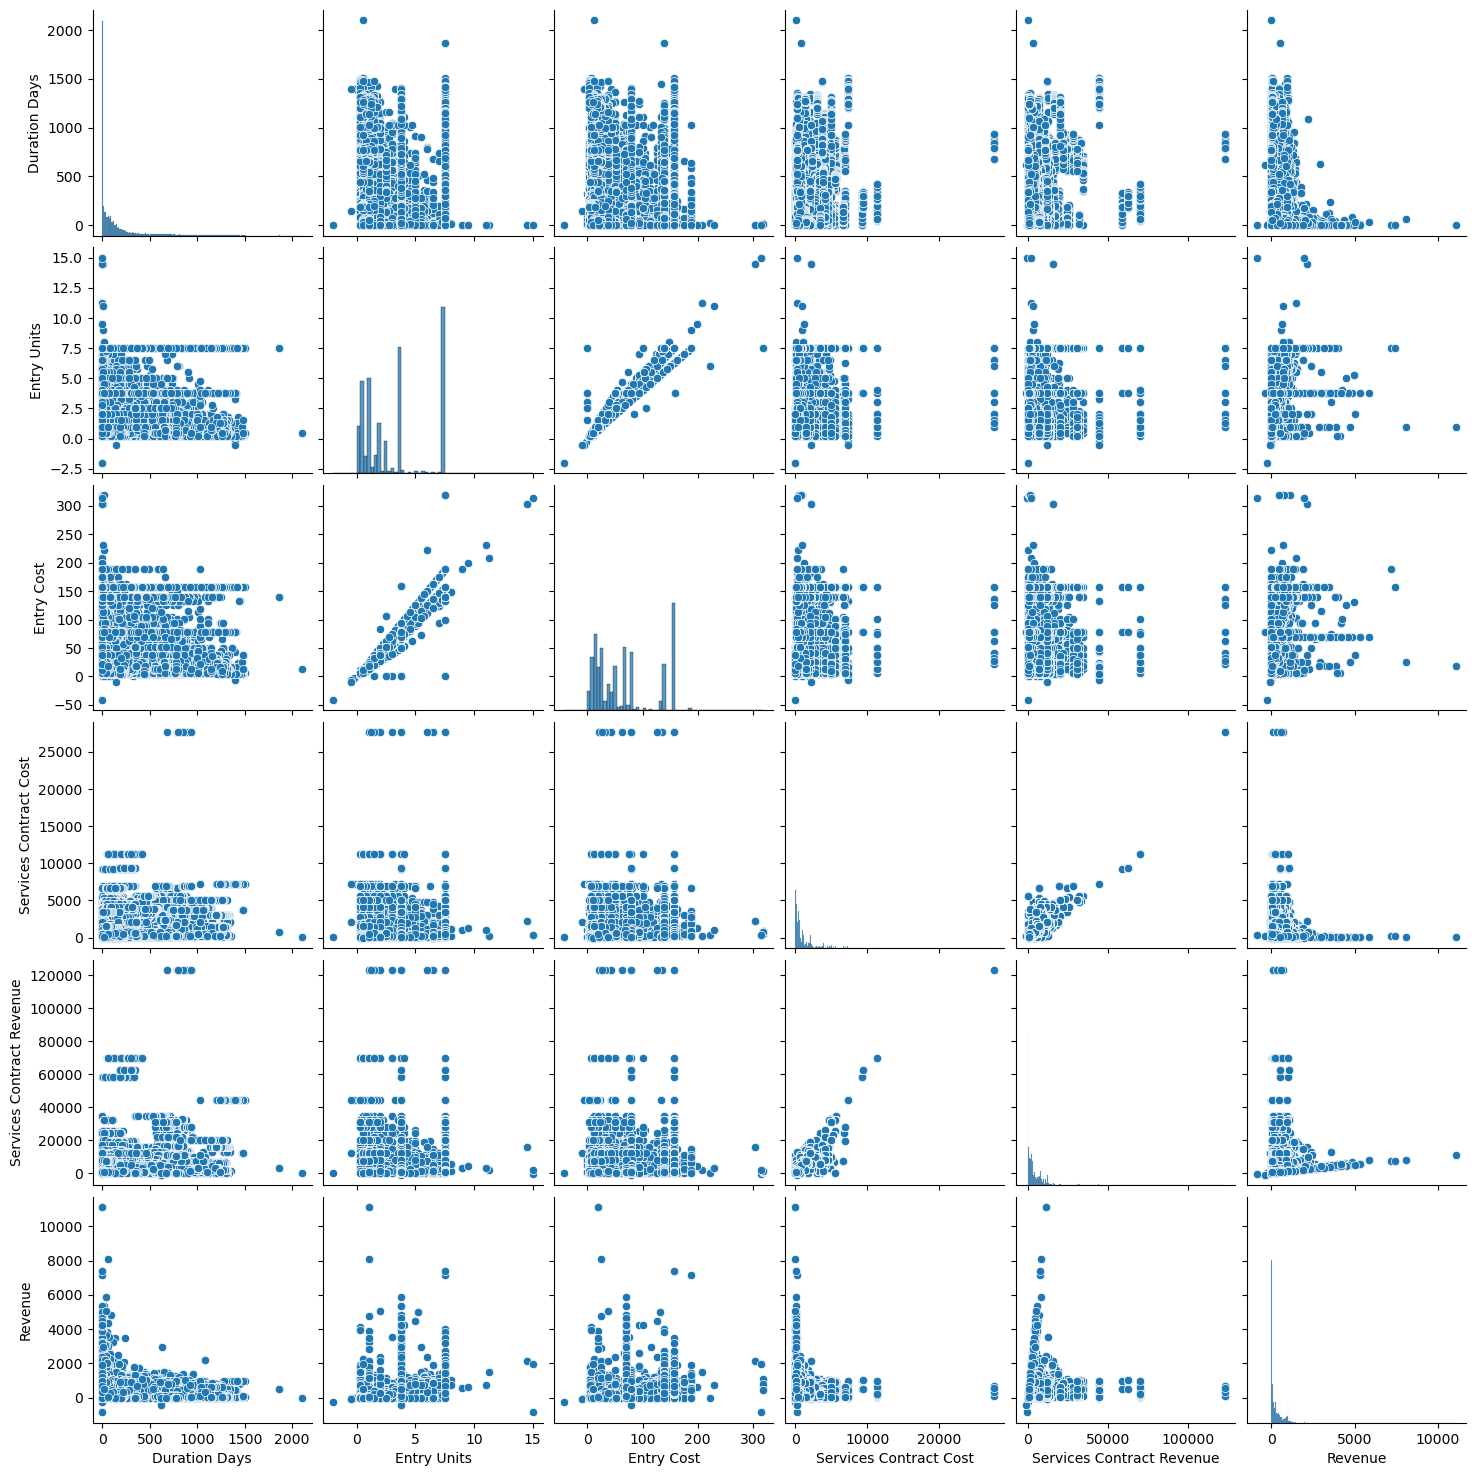

In [51]:
sns.pairplot(df[num_analysis])
plt.show()

In [52]:
num_analysis_in = df.select_dtypes(include = ['int64', 'float64'])

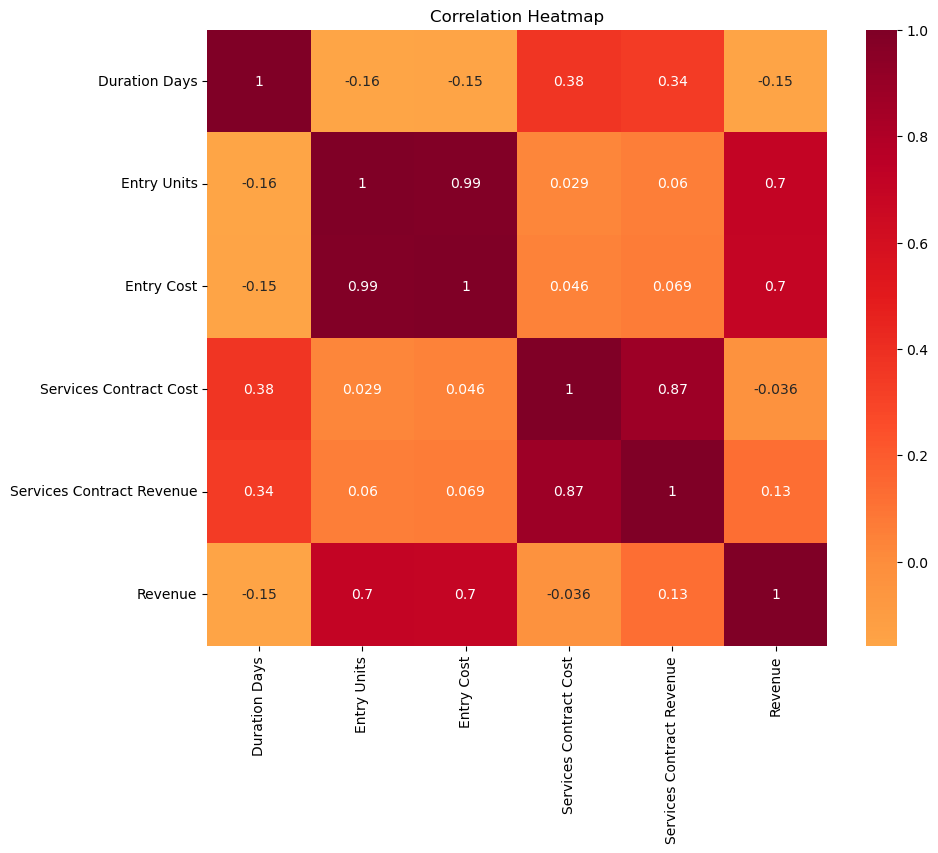

In [53]:
correlation_matrix = num_analysis_in.corr()
plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'YlOrRd', center = 0)
plt.title('Correlation Heatmap')
plt.show()

In [54]:
correlation_threshold = 0.5

In [55]:
highly_correlated_pairs = [
    (correlation_matrix.columns[i], correlation_matrix.columns[j])
    for i in range(len(correlation_matrix.columns))
    for j in range(i + 1, len(correlation_matrix.columns))
    if abs(correlation_matrix.iloc[i, j]) > correlation_threshold
]

In [56]:
print("Highly Correlated Pairs:")
for pair in highly_correlated_pairs:
    correlation_value = correlation_matrix.loc[pair]
    print(f"{pair[0]} - {pair[1]}: {correlation_value:.2f}")

Highly Correlated Pairs:
Entry Units - Entry Cost: 0.99
Entry Units - Revenue: 0.70
Entry Cost - Revenue: 0.70
Services Contract Cost - Services Contract Revenue: 0.87


<b><font size='3'>Data Pre-Processing 1 - Removing Outliers</font></b>

In [57]:
df = df[df['Duration Days'] <= 1600]

In [58]:
df = df[df['Revenue'] <= 11000]

<b><font size='3'>Others 1 - Output to CSV</font></b>

In [59]:
df.to_csv('Services_Data_Cleaned.csv', index = False, header = True, mode = 'w')

In [60]:
df_model = df.copy()

<b><font size='3'>Data Pre-Processing 2 - Target Selection</font></b>

In [61]:
df_model['Target'] = (df_model['Revenue'] >= 500).astype(int)

In [62]:
df_model['Target'].value_counts()

0    41724
1    13239
Name: Target, dtype: int64

In [63]:
drop_col = ['Entry Cost', 'Services Contract Cost', 'Services Contract Revenue', 'Revenue', 
            'Sign Date', 'Entry Date', 'Element End Date']

df_model.drop(columns = drop_col, inplace = True)

In [64]:
df_model.reset_index(drop = True, inplace = True)

In [65]:
df_model

,Engagement Account,Engagement,Element,Resource,Duration Days,Entry Units,Target
0,Hermes Parcelnet Limited,Hermes - Additional Days,Project Management,Bridget Casement,237,2.00,0
1,Hermes Parcelnet Limited,Hermes - Additional Days,Project Management,Bridget Casement,230,1.00,0
2,Hermes Parcelnet Limited,Hermes - Additional Days,Project Management,Bridget Casement,238,2.00,0
3,Hermes Parcelnet Limited,Hermes - Additional Days,Project Management,Bridget Casement,217,1.00,0
4,Hermes Parcelnet Limited,Hermes - Additional Days,Project Management,Bridget Casement,216,1.50,0
...,...,...,...,...,...,...,...
54958,Zenith Multi Academy Trust,Zenith - IF - Doc Attach,IRIS Financials Education Ad Hoc Consultancy,Veerinder Bhoda,0,7.50,1
54959,Zenith Multi Academy Trust,Migrated PSF:KIN05-3:Zenith Multi Academy Trust,IRIS Financials Advantage Plus Service,Amira Varia,67,3.75,0
54960,Zenith Multi Academy Trust,Migrated PSF:KIN05-3:Zenith Multi Academy Trust,IRIS Financials Advantage Plus Service,Manjit Biant,78,7.50,0
54961,Zenith Multi Academy Trust,Migrated PSF:KIN05-3:Zenith Multi Academy Trust,IRIS Financials Advantage Plus Service,Manjit Biant,59,1.00,0


In [66]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54963 entries, 0 to 54962
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Engagement Account  54963 non-null  object 
 1   Engagement          54963 non-null  object 
 2   Element             54963 non-null  object 
 3   Resource            54963 non-null  object 
 4   Duration Days       54963 non-null  int64  
 5   Entry Units         54963 non-null  float64
 6   Target              54963 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(4)
memory usage: 2.7+ MB


<b><font size='3'>Data Pre-Processing 3 - Applied OneHotEncoder & StandardScaler</font></b>

In [67]:
# Identify the Categorical & Numerical Columns

categorical_cols = df_model.select_dtypes(include=['object']).columns
numerical_cols = df_model.select_dtypes(include=['int64', 'float64']).columns

In [68]:
# Prepare the Feature Matrix and Target Vector for Modelling

x = pd.get_dummies(df_model.drop('Target', axis=1), columns = categorical_cols)
y = df_model['Target']

In [69]:
# Split the Data to Training & Test Sets

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 42)

In [70]:
# Standardize the Numerical Features

scaler = StandardScaler()

x_train[numerical_cols] = scaler.fit_transform(x_train[numerical_cols])
x_test[numerical_cols] = scaler.transform(x_test[numerical_cols])

<b><font size='3'>Model Creation & Training 1 - Reduced Learning Rate & Class Weights</font></b>

In [71]:
# Create the Neural Network Model

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(16, input_dim = x_train.shape[1], activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [72]:
# Compile the Model

model.compile(optimizer = Adam(learning_rate = 0.0003), 
              loss = 'binary_crossentropy', 
              metrics = 'accuracy')

In [73]:
# Display the Model Architecture

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                255872    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 255889 (999.57 KB)
Trainable params: 255889 (999.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
# Compute Class Weights for Imbalanced Classes

class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
class_weights = dict(enumerate(class_weights))

In [75]:
# Print the Computed Class Weights

print("Class Weights:", class_weights)

Class Weights: {0: 0.6586476527157794, 1: 2.0758190916816166}


In [76]:
# Train the Model on the Training Data

history = model.fit(x_train, y_train,
                    verbose = 2,
                    epochs = 20, 
                    batch_size = 320, 
                    validation_data = (x_test, y_test),
                    class_weight = class_weights)

Epoch 1/20
138/138 - 5s - loss: 0.6365 - accuracy: 0.7063 - val_loss: 0.6102 - val_accuracy: 0.7820 - 5s/epoch - 39ms/step
Epoch 2/20
138/138 - 3s - loss: 0.5134 - accuracy: 0.8030 - val_loss: 0.5095 - val_accuracy: 0.8121 - 3s/epoch - 23ms/step
Epoch 3/20
138/138 - 3s - loss: 0.4194 - accuracy: 0.8335 - val_loss: 0.4245 - val_accuracy: 0.8374 - 3s/epoch - 22ms/step
Epoch 4/20
138/138 - 3s - loss: 0.3564 - accuracy: 0.8585 - val_loss: 0.3631 - val_accuracy: 0.8588 - 3s/epoch - 22ms/step
Epoch 5/20
138/138 - 3s - loss: 0.3128 - accuracy: 0.8760 - val_loss: 0.3200 - val_accuracy: 0.8775 - 3s/epoch - 22ms/step
Epoch 6/20
138/138 - 3s - loss: 0.2843 - accuracy: 0.8880 - val_loss: 0.2896 - val_accuracy: 0.8906 - 3s/epoch - 23ms/step
Epoch 7/20
138/138 - 3s - loss: 0.2614 - accuracy: 0.8997 - val_loss: 0.2688 - val_accuracy: 0.8988 - 3s/epoch - 22ms/step
Epoch 8/20
138/138 - 3s - loss: 0.2456 - accuracy: 0.9067 - val_loss: 0.2530 - val_accuracy: 0.9052 - 3s/epoch - 23ms/step
Epoch 9/20
138/1

<b><font size='3'>Model Evaluation 1 - Accuracy & Loss Plots, Confusion Matrix, & Metrics</font></b>

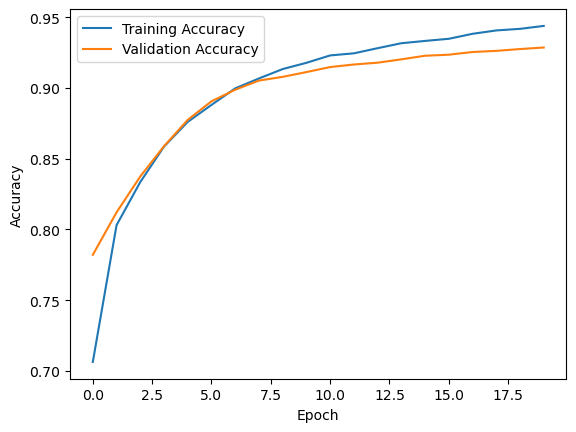

In [77]:
# Plot the Accuracy

plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

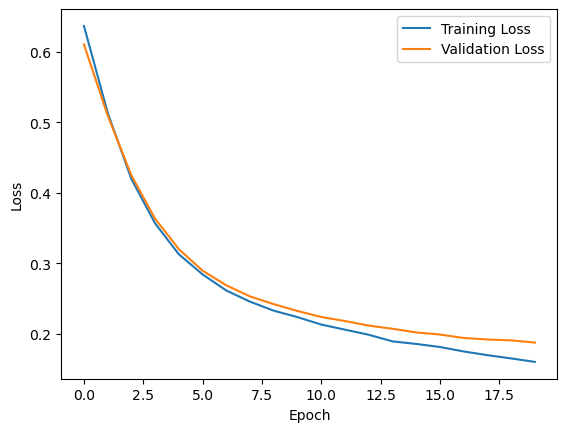

In [78]:
# Plot the Loss

plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [79]:
# Use Model to Predict

y_pred = model.predict(x_test)

344/344 [==============================] - 1s 3ms/step


In [80]:
# Convert Prediction to Binary

y_pred_binary = (y_pred > 0.5).astype(int)

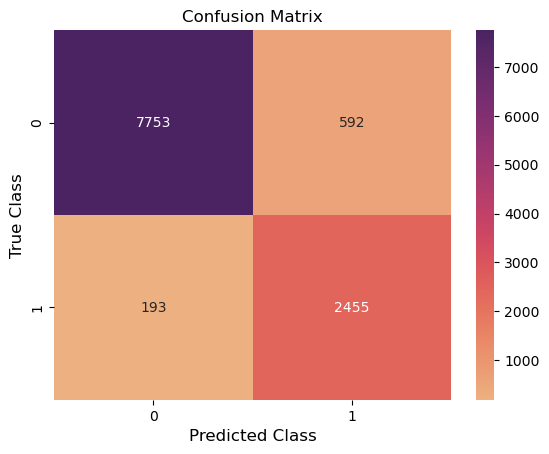

In [81]:
# Plot the Confusion Matrix

confusion_matrix = confusion_matrix(y_test, y_pred_binary)
ax = sns.heatmap(confusion_matrix, cmap = 'flare', annot = True, fmt = 'd')

plt.xlabel("Predicted Class", fontsize = 12)
plt.ylabel("True Class", fontsize = 12)
plt.title("Confusion Matrix", fontsize = 12)
plt.show()

In [82]:
# Create a Classification Report

report = classification_report(y_test, y_pred_binary)

print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      8345
           1       0.81      0.93      0.86      2648

    accuracy                           0.93     10993
   macro avg       0.89      0.93      0.91     10993
weighted avg       0.93      0.93      0.93     10993



In [83]:
# Calculate and Round Evaluation Metrics

accuracy = round(accuracy_score(y_test, y_pred_binary), 2)
average_precision = round(average_precision_score(y_test, y_pred), 2)
log_loss_val = round(log_loss(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred_binary), 2)
mcc = round(matthews_corrcoef(y_test, y_pred_binary), 2)

In [84]:
# Print the Evaluation Results

print('Accuracy:', accuracy)
print('Average Precision Score:', average_precision)
print('Log Loss:', log_loss_val)
print('F1 Score:', f1)
print('Matthews Correlation Coeffiecient:', mcc)

Accuracy: 0.93
Average Precision Score: 0.94
Log Loss: 0.19
F1 Score: 0.86
Matthews Correlation Coeffiecient: 0.82


In [85]:
# Identify the Model Weights & Original Feature Names

model_weights = model.get_weights()[0]
feature_names = x.columns

In [86]:
# Calculate the Feature Importance

feature_importances = np.abs(model_weights).mean(axis=1)

In [87]:
# Sort and Select Top Features

sorted_indices = np.argsort(feature_importances)[::-1]
top_feature_indices = sorted_indices[:10]
top_feature_names = feature_names[top_feature_indices]
top_feature_importances = feature_importances[top_feature_indices]

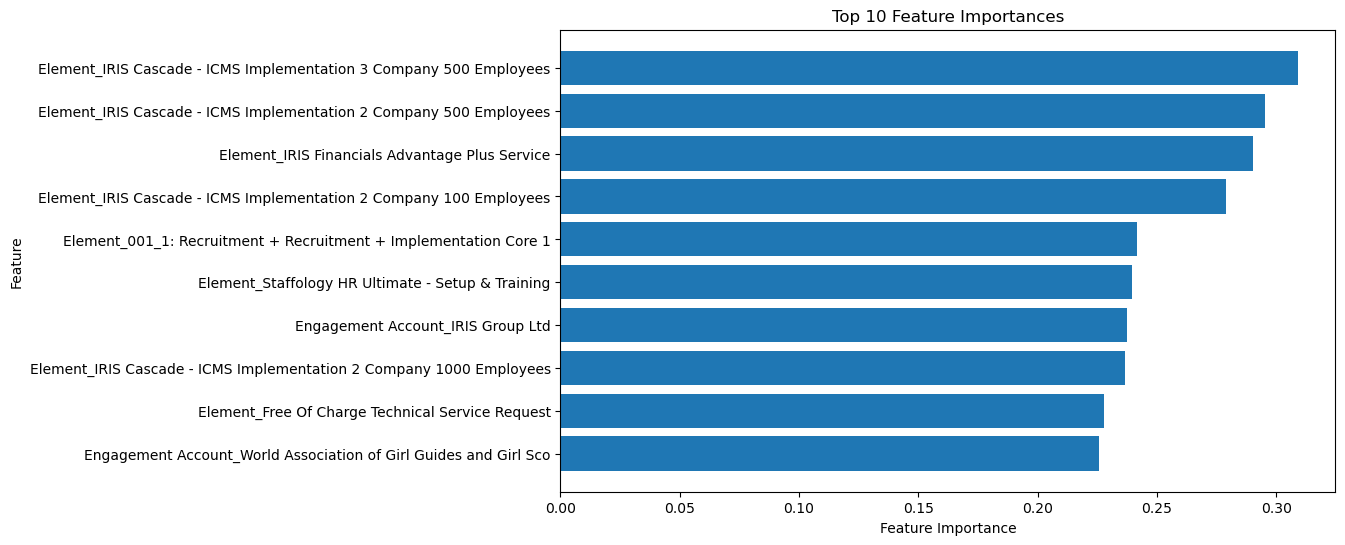

In [88]:
# Plot the Feature Importance

plt.figure(figsize = (10, 6))
plt.barh(top_feature_names[::-1], top_feature_importances[::-1])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.show()

In [89]:
# Create a Function to Aggregate Feature Importance

def calculate_aggregated_importances(feature_names, model_weights):
    feature_mapping = {}
    for col_name in feature_names:
        original_feature = col_name.split('_')[0]
        feature_mapping.setdefault(original_feature, []).append(col_name)

    aggregated_feature_importances = []
    for original_feature, cols in feature_mapping.items():
        indices = [feature_names.get_loc(col) for col in cols]
        importance_values = np.abs(model_weights[indices]).mean(axis=0)
        aggregated_importance = np.mean(importance_values)
        aggregated_feature_importances.append((original_feature, aggregated_importance))

    return sorted(aggregated_feature_importances, key = lambda x: x[1], reverse = True)[:10]

In [90]:
# Aggregate the Binary Feature Importance

top_aggregated_feature_importances = calculate_aggregated_importances(feature_names, model_weights)
top_feature_names, top_feature_importances = zip(*top_aggregated_feature_importances)

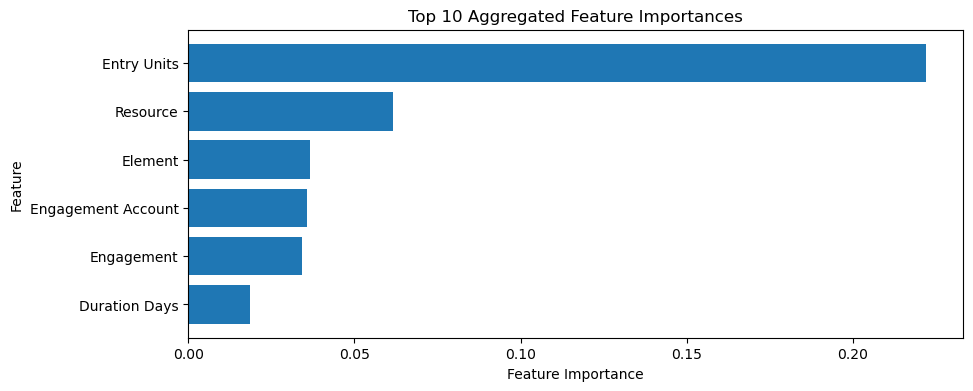

In [91]:
# Plot the Aggregated Feature Importance

plt.figure(figsize=(10, 4))
plt.barh(top_feature_names[::-1], top_feature_importances[::-1])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Aggregated Feature Importances')
plt.show()

<b><font size='3'>Analysis 5 - Results & Findings</font></b>

In [92]:
df_2023 = df[df['Entry Date'].dt.year == 2023].reset_index(drop = True)

In [93]:
df_2023

,Engagement Account,Engagement,Element,Resource,Sign Date,Entry Date,Element End Date,Duration Days,Entry Units,Entry Cost,Services Contract Cost,Services Contract Revenue,Revenue
0,1PhysioUK Limited,1PhysioUK Limited - FMP + HR,Free of Charge - Provisioning (E012194-004),Haroon Sarwar,NaT,2023-06-06,2023-06-06,0,1.00,20.93,20.93,0.00,0.00
1,2M Holdings Ltd,2M - 3 days training/consultancy (Early Bird O...,Ad-Hoc Consultancy,Usayd Latif,NaT,2023-01-11,2023-02-28,48,3.75,78.50,157.00,895.46,447.73
2,2M Holdings Ltd,2M - 3 days training/consultancy (Early Bird O...,Ad-Hoc Consultancy,Simon Clark-Jones,NaT,2023-02-28,2023-02-28,0,3.75,78.50,157.00,895.46,447.73
3,3-18 Education Trust,3-18 Education Trust (The) - IRIS Financials A...,IRIS Financials Education Accounting Add Locat...,Ashley Stokes,NaT,2023-03-24,2023-03-24,0,7.50,157.00,314.00,1999.95,999.98
4,3-18 Education Trust,3-18 Education Trust (The) - IRIS Financials A...,IRIS Financials Education Accounting Add Locat...,Ashley Stokes,NaT,2023-03-22,2023-03-24,2,7.50,157.00,314.00,1999.95,999.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10956,Zenith Bank,Zenith Bank - Cascade - FOC Consultancy,Ad-Hoc Consultancy,Adnan Yusuf,NaT,2023-04-29,2023-04-29,0,7.50,188.00,188.00,0.00,0.00
10957,Zenith Multi Academy Trust,Migrated PSF:KIN05-3:Zenith Multi Academy Trust,IRIS Financials Advantage Plus Service,Amira Varia,NaT,2023-04-24,2023-06-30,67,3.75,69.50,456.63,810.00,123.28
10958,Zenith Multi Academy Trust,Migrated PSF:KIN05-3:Zenith Multi Academy Trust,IRIS Financials Advantage Plus Service,Manjit Biant,NaT,2023-04-13,2023-06-30,78,7.50,139.00,456.63,810.00,246.57
10959,Zenith Multi Academy Trust,Migrated PSF:KIN05-3:Zenith Multi Academy Trust,IRIS Financials Advantage Plus Service,Manjit Biant,NaT,2023-05-02,2023-06-30,59,1.00,18.53,456.63,810.00,32.87


In [94]:
def create_pie_chart(labels, sizes, title):
    cmap = plt.get_cmap('flare')

    plt.pie(sizes, labels = labels, colors = cmap(np.linspace(0, 1, len(labels))),
            autopct = '%1.1f%%', shadow = True, startangle = 140)
    plt.axis('Equal')
    plt.title(title)
    plt.show()

In [95]:
foc_count = df_2023['Element'].str.contains('FOC|Free of Charge', case=False).sum()
staf_count = df_2023['Element'].str.contains('Staffology HR', case=False).sum()

total_count = len(df_2023)
other_count = total_count - (foc_count + staf_count)

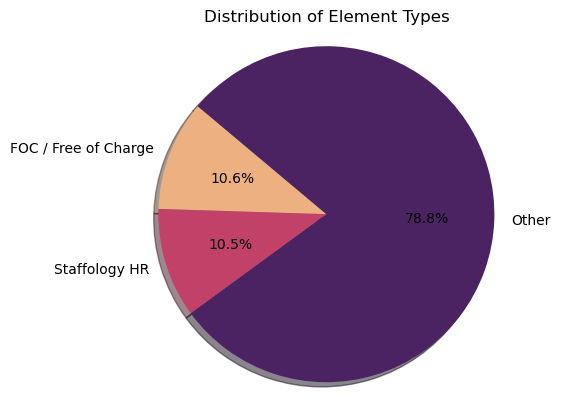

In [96]:
element_labels = ['FOC / Free of Charge', 'Staffology HR', 'Other']
element_sizes = [foc_count, staf_count, other_count]
create_pie_chart(element_labels, element_sizes, 'Distribution of Element Types')

In [97]:
foc_revenue_sum = df_2023[df_2023['Element'].str.contains('FOC|Free of Charge', case=False, na=False)]['Revenue'].sum()

print("FOC Revenue Sum:", foc_revenue_sum)

FOC Revenue Sum: 0.0


In [98]:
staffology_hr_engagements = df_2023[df_2023['Element'].str.contains('Staffology HR', case=False, na=False)]

positive_revenue_count = (staffology_hr_engagements['Revenue'] > 0).sum()
negative_revenue_count = (staffology_hr_engagements['Revenue'] <= 0).sum()

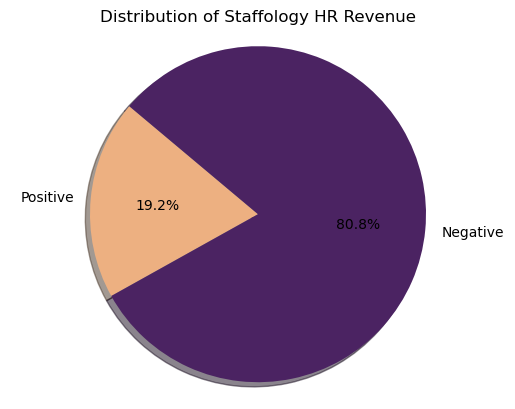

In [99]:
revenue_labels = ['Positive', 'Negative']
revenue_sizes = [positive_revenue_count, negative_revenue_count]
create_pie_chart(revenue_labels, revenue_sizes, 'Distribution of Staffology HR Revenue')

In [100]:
foc_df = df_2023[df_2023['Element'].str.contains('FOC|Free of Charge', case=False, na=False)]
foc_counts = foc_df['Resource'].value_counts().reset_index()
foc_counts.columns = ['Resource', 'FOC Count']

total_counts = df_2023['Resource'].value_counts().reset_index()
total_counts.columns = ['Resource', 'Total Count']

combined_counts = pd.merge(foc_counts, total_counts, on='Resource', how='left')
combined_counts = combined_counts[combined_counts['Total Count'] > 1]
combined_counts['Percentage'] = (combined_counts['FOC Count'] / combined_counts['Total Count']) * 100

top_10_resources = combined_counts.sort_values(by='FOC Count', ascending=False).head(10)

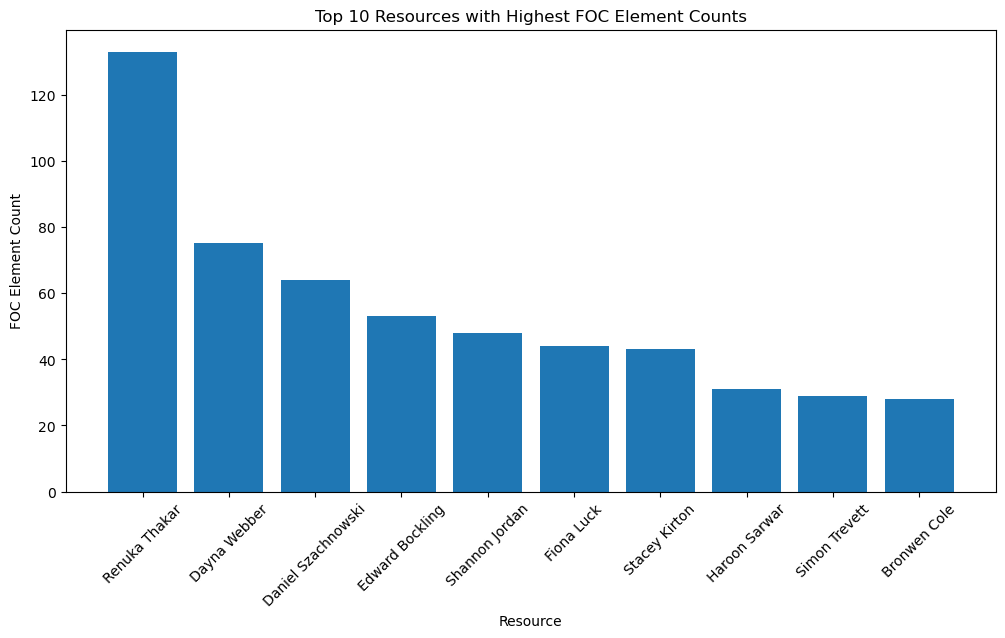

In [101]:
plt.figure(figsize=(12, 6))
plt.bar(top_10_resources['Resource'], top_10_resources['FOC Count'])
plt.title('Top 10 Resources with Highest FOC Element Counts')
plt.xlabel('Resource')
plt.ylabel('FOC Element Count')
plt.xticks(rotation=45)
plt.show()

In [102]:
print(top_10_resources[['Resource', 'FOC Count', 'Total Count', 'Percentage']])

             Resource  FOC Count  Total Count  Percentage
0       Renuka Thakar        133          356   37.359551
1        Dayna Webber         75          379   19.788918
2  Daniel Szachnowski         64          446   14.349776
3     Edward Bockling         53           80   66.250000
4      Shannon Jordan         48          323   14.860681
5          Fiona Luck         44          336   13.095238
6       Stacey Kirton         43          350   12.285714
7       Haroon Sarwar         31          259   11.969112
8       Simon Trevett         29          120   24.166667
9        Bronwen Cole         28          156   17.948718


In [103]:
parentmail_engagements = df_2023[df_2023['Element'].str.contains('IRIS ParentMail Communications Implementation|Parentmail Parents', case=False, na=False)]

positive_revenue_count = (parentmail_engagements['Revenue'] > 0).sum()
negative_revenue_count = (parentmail_engagements['Revenue'] <= 0).sum()

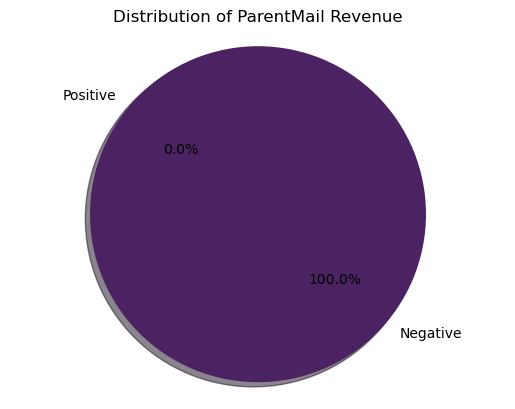

In [104]:
revenue_labels = ['Positive', 'Negative']
revenue_sizes = [positive_revenue_count, negative_revenue_count]
create_pie_chart(revenue_labels, revenue_sizes, 'Distribution of ParentMail Revenue')

In [105]:
hrstandard_engagements = df_2023[df_2023['Element'].str.contains('IRIS HR Professional Standard', case = False, na = False)]

positive_revenue_count = (parentmail_engagements['Revenue'] > 0).sum()
negative_revenue_count = (parentmail_engagements['Revenue'] <= 0).sum()

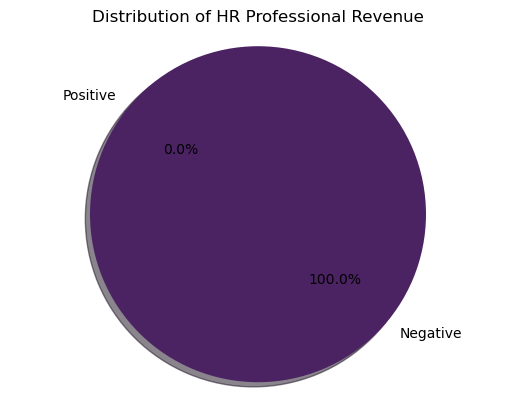

In [106]:
revenue_labels = ['Positive', 'Negative']
revenue_sizes = [positive_revenue_count, negative_revenue_count]
create_pie_chart(revenue_labels, revenue_sizes, 'Distribution of HR Professional Revenue')

In [107]:
cheadle_hulme_school = df_2023[df_2023['Engagement Account'] == 'Cheadle Hulme School']
element_frequency = cheadle_hulme_school['Element'].value_counts()

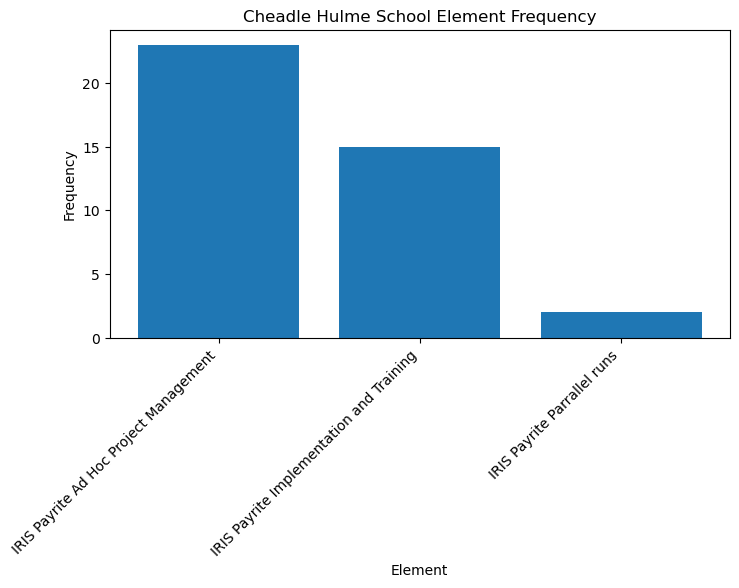

In [108]:
fig, ax1 = plt.subplots(figsize = (8, 4))

element_frequency = cheadle_hulme_school['Element'].value_counts()
bars = ax1.bar(element_frequency.index, element_frequency.values)
ax1.set_xlabel('Element')
ax1.set_ylabel('Frequency')

ax1.set_xticks(range(len(element_frequency.index)))
ax1.set_xticklabels(element_frequency.index, rotation = 45, ha = 'right')
ax1.set_title('Cheadle Hulme School Element Frequency')

plt.show()

In [109]:
cheadle_revenue_sum = df_2023[df_2023['Engagement Account'].str.contains('Cheadle', case = False, na = False)]['Revenue'].sum()

print("Cheadle Hulme Revenue Sum:", cheadle_revenue_sum)

Cheadle Hulme Revenue Sum: 0.0
